# 1. Introduction

A brief description of your approach to the problem and the results that you 
have obtained on the training data.

\*Insert Introduction here\*

# 2. Data Import

This section is how you import the data into the notebook. It should be written in such 
a way that I can modify it to run on my own machine by simply changing the location 
of the training data and any additional data sources that you have used.

In [16]:
# I intend to use Data Frames to hold our data for now. When putting it in the model,
# I will probably have to change it to another format later but that is a problem for future me, not current me
# (Im joking; please dont deduct points, Mr/Ms Marker)
# Seriously though, Data Frames have very good performance and are malleable for data investigation,
# hence my decision to use them.

import pandas as pd
from pandas import DataFrame as df
import csv

def dataframe_from_diabetic_data_csv(csv_filepath):
    return pd.read_csv(csv_filepath)

TRAINING_DATA_FILEPATH = "BENG0095 (202425) Group Coursework Brief-20251122/Dataset/diabetic_data_training.csv"
TEST_DATA_FILEPATH = "BENG0095 (202425) Group Coursework Brief-20251122/Dataset/diabetic_data_test.csv"

training_data = dataframe_from_diabetic_data_csv(TRAINING_DATA_FILEPATH)
test_data = dataframe_from_diabetic_data_csv(TEST_DATA_FILEPATH)

print(training_data)



       encounter_id  patient_nbr             race  gender      age weight  \
0            149190     55629189        Caucasian  Female  [10-20)      ?   
1             64410     86047875  AfricanAmerican  Female  [20-30)      ?   
2            500364     82442376        Caucasian    Male  [30-40)      ?   
3             16680     42519267        Caucasian    Male  [40-50)      ?   
4             35754     82637451        Caucasian    Male  [50-60)      ?   
...             ...          ...              ...     ...      ...    ...   
91584     443847548    100162476  AfricanAmerican    Male  [70-80)      ?   
91585     443847782     74694222  AfricanAmerican  Female  [80-90)      ?   
91586     443854148     41088789        Caucasian    Male  [70-80)      ?   
91587     443857166     31693671        Caucasian  Female  [80-90)      ?   
91588     443867222    175429310        Caucasian    Male  [70-80)      ?   

       admission_type_id  discharge_disposition_id  admission_source_id  \


# 3. Data Transformation and Exploration
Code for the equivalent section in your report, together with in-line documentation of 
that code.

In [ ]:
# Data transformations

# In this section, we create some helper functions that can help transform the data
# This includes cleaning the data. 
# Applying these functions results in better visualisations and insights into the data
# These functions can also be easily called for preprocessing before passing training data into model

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

df = pd.read_csv(TRAINING_DATA_FILEPATH)

print(df.columns)

categorical_features = ['race', 'gender', 'admission_type_id', 'discharge_disposition_id']
numerical_features = ['age_midpoint', 'number_inpatient', 'number_emergency', 'time_in_hospital']


def clean_inpatient_data():
    global df

    cols = ["number_inpatient", "number_outpatient", "number_emergency"]

    df[cols] = df[cols].apply(pd.to_numeric, errors="coerce")

    # Replace NaN with 0 (patients often have no prior visits)
    df[cols] = df[cols].fillna(0)

    # Clip extreme outliers (very rare >10 visits)
    df[cols] = df[cols].clip(0, 10)

    df["total_visits"] = df["number_inpatient"] + df["number_outpatient"] + df["number_emergency"]

    df[cols + ["total_visits"]]

def clean_patient_interaction_cols():
    global df 

    encounter_cols = [
        "time_in_hospital",
        "admission_type_id",
        "discharge_disposition_id",
        "admission_source_id"
    ]

    # Convert to numeric
    df[encounter_cols] = df[encounter_cols].apply(pd.to_numeric, errors="coerce")

    # Replace any NaN with a special category (rare)
    df[["admission_type_id", "discharge_disposition_id", "admission_source_id"]] = \
        df[["admission_type_id", "discharge_disposition_id", "admission_source_id"]].fillna(-1)

    # Ensure time_in_hospital has no NaN
    df["time_in_hospital"] = df["time_in_hospital"].fillna(df["time_in_hospital"].median())


def standard_cleaning():
    #dropping na/invalid values

    global df
    df = df[df['age_midpoint'].notna()]
    df = df[df['race'] != '?']
    df = df[df['gender'] != 'Unknown/Invalid']
    return

def get_age_mid(row):
    row = row[1:-1]
    start, end = list(map(int, row.split("-")))
    return (start + end) / 2

def make_preprocessor():
    return ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
            ('num', StandardScaler(), numerical_features)
        ]
    )

df["age_midpoint"] = df["age"].apply(get_age_mid)


clean_inpatient_data()

clean_patient_interaction_cols()

standard_cleaning()


Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')


In [18]:
# In the following sections we plot graphs that can visualise this cleaned data to get some insights into what fields are important for model building

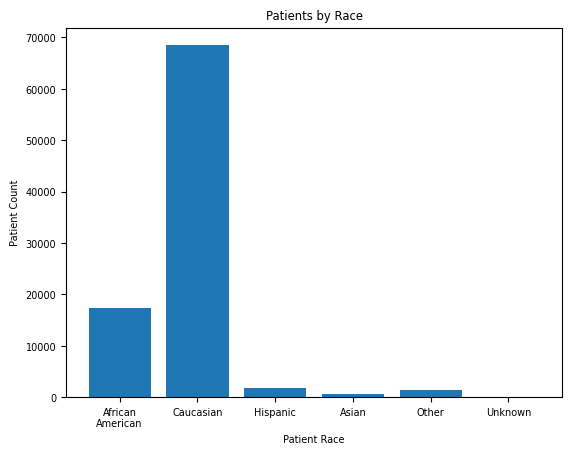

In [19]:
# Grouping by race to get some insights into frequency of patients by race
import seaborn as sns
from matplotlib import pyplot as plt

african_americans = df[df['race']=='AfricanAmerican']
african_american_patients = len(african_americans)

caucasians = df[df['race'] == 'Caucasian']
caucasian_patients = len(caucasians)

hispanics = df[df['race'] == 'Hispanic']
hispanic_patients = len(hispanics)

asians = df[df['race'] == 'Asian']
asian_patients = len(asians)

others = df[df['race'] == 'Other']
other_race_patients = len(others)

unknowns = df[df['race'] == '?']
unknown_race_patients = len(unknowns)

races = ['African\nAmerican', 'Caucasian', 'Hispanic', 'Asian', 'Other', 'Unknown']
patient_counts = [african_american_patients, caucasian_patients, hispanic_patients, asian_patients, other_race_patients, unknown_race_patients]

plt.bar(races, patient_counts)
plt.title("Patients by Race")
plt.xlabel("Patient Race")
plt.ylabel("Patient Count")
plt.show()


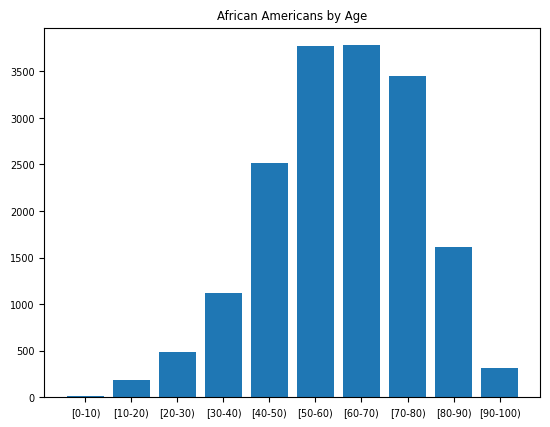

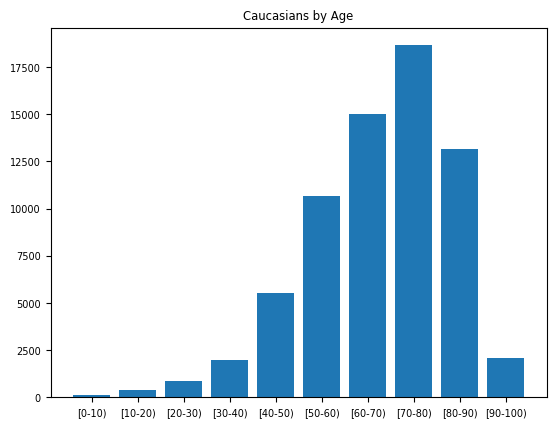

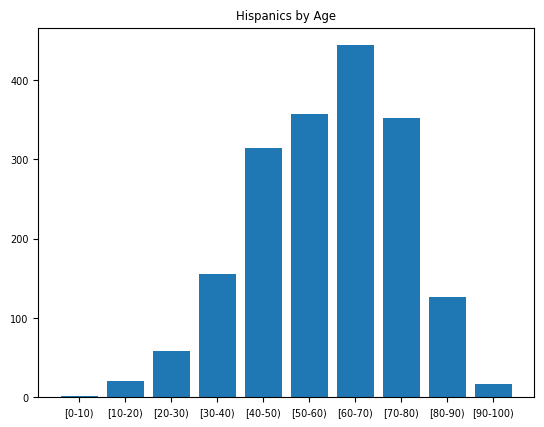

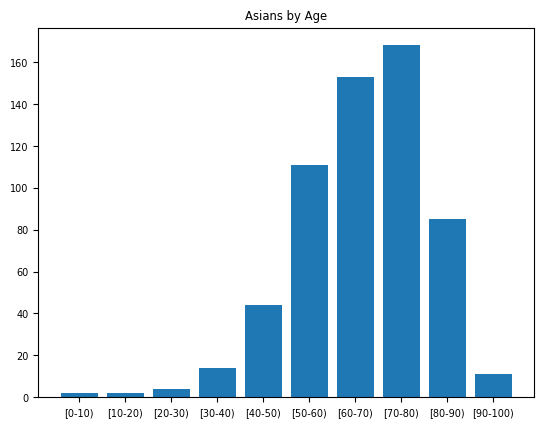

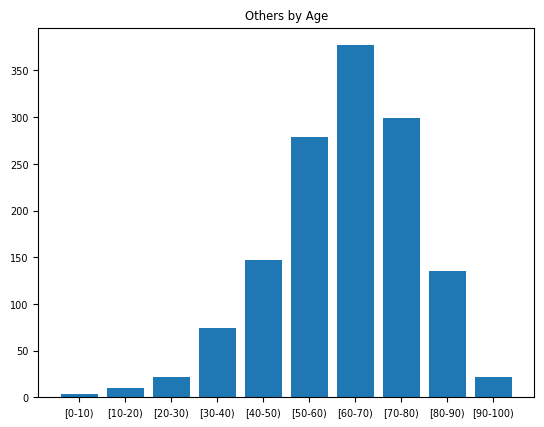

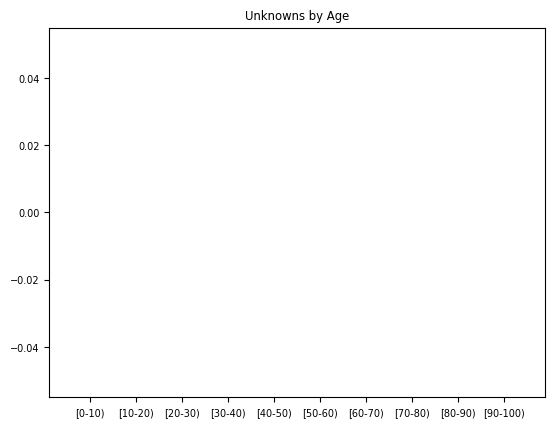

In [20]:
# Grouping patients by age within race
# '[10-20)' '[20-30)' '[30-40)' '[40-50)' '[50-60)' '[60-70)' '[70-80)' '[80-90)' '[90-100)' '[0-10)'
age_brackets = ['[0-10)', '[10-20)', '[20-30)', '[30-40)', '[40-50)', '[50-60)', '[60-70)', '[70-80)', '[80-90)', '[90-100)']
african_americans_by_age = [len(african_americans[african_americans['age'] == bracket]) for bracket in age_brackets]
caucasians_by_age = [len(caucasians[caucasians['age'] == bracket]) for bracket in age_brackets]
hispanics_by_age = [len(hispanics[hispanics['age'] == bracket]) for bracket in age_brackets]
asians_by_age = [len(asians[asians['age'] == bracket]) for bracket in age_brackets]
others_by_age = [len(others[others['age'] == bracket]) for bracket in age_brackets]
unknowns_by_age = [len(unknowns[unknowns['age'] == bracket]) for bracket in age_brackets]

plt.rcParams.update({'font.size': 7})

plt.bar(age_brackets, african_americans_by_age)
plt.title('African Americans by Age')
plt.show()

plt.bar(age_brackets, caucasians_by_age)
plt.title('Caucasians by Age')
plt.show()

plt.bar(age_brackets, hispanics_by_age)
plt.title('Hispanics by Age')
plt.show()

plt.bar(age_brackets, asians_by_age)
plt.title('Asians by Age')
plt.show()

plt.bar(age_brackets, others_by_age)
plt.title('Others by Age')
plt.show()

plt.bar(age_brackets, unknowns_by_age)
plt.title('Unknowns by Age')
plt.show()

plt.rcParams.clear()


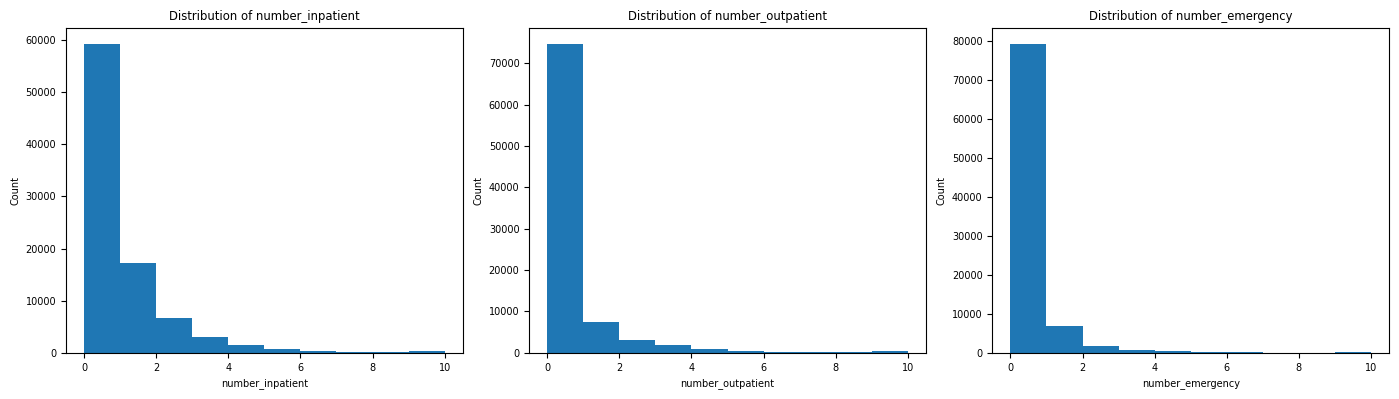

In [21]:

# understanding frequency and grouping of number_inpatient, number_outpatient and number_emergency

cols = ["number_inpatient", "number_outpatient", "number_emergency"]

plt.figure(figsize=(14,4))

for i, col in enumerate(cols):
    plt.subplot(1, 3, i+1)
    plt.hist(df[col], bins=10)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")

plt.tight_layout()
plt.show()


/var/folders/2_/cs6k5z6129j71cv3p08t5vym0000gn/T/ipykernel_90304/757154414.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(df[cols], labels=cols)


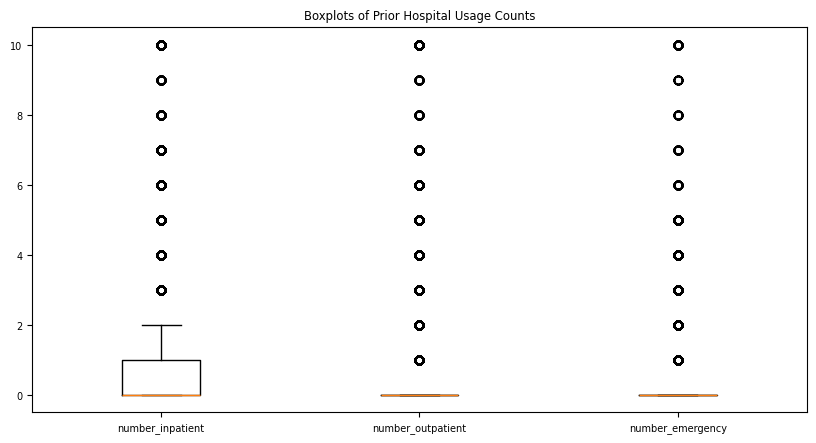

In [22]:
# understanding prior interaction with hospital after removing outliers
plt.figure(figsize=(10,5))
plt.boxplot(df[cols], labels=cols)
plt.title("Boxplots of Prior Hospital Usage Counts")
plt.show()


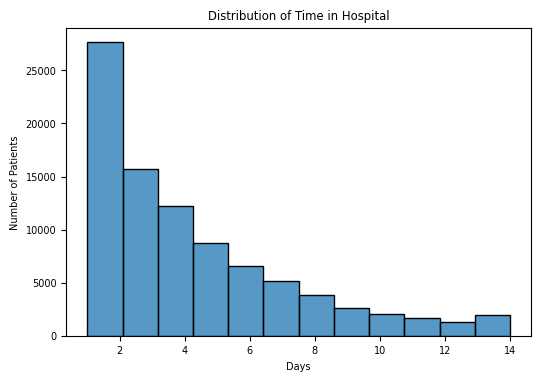

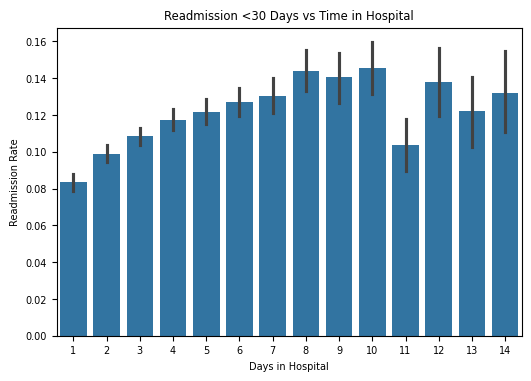

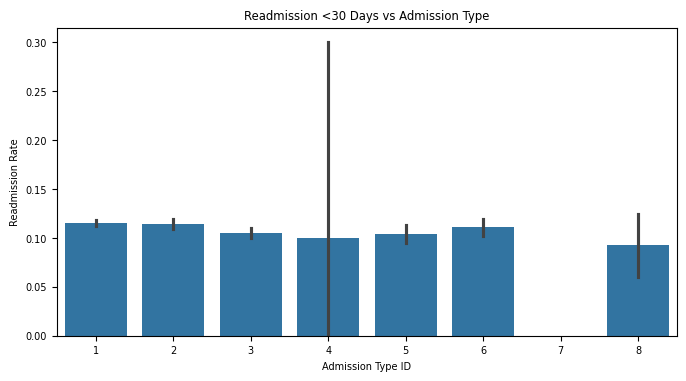

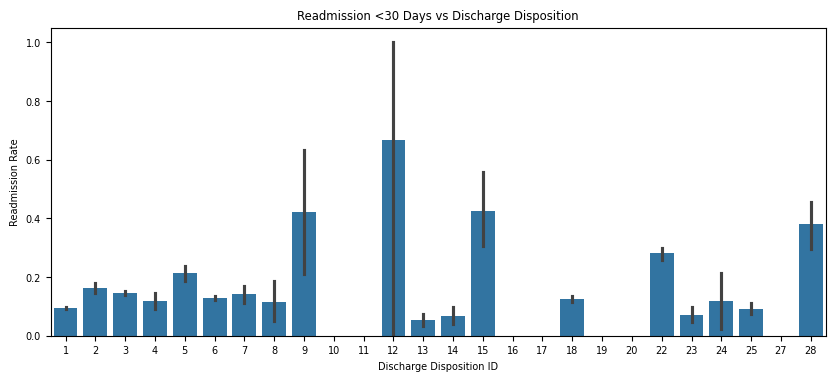

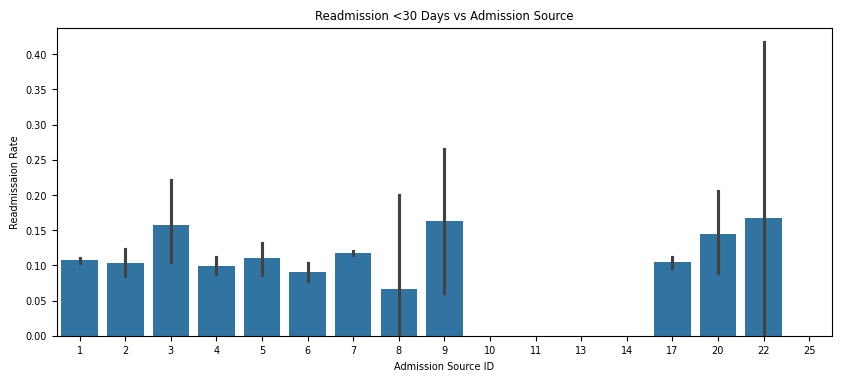

In [23]:
# plotting more fields regarding patient's prior interaction with hospital and their readmission rates
# this is to see which fields have some relationship to readmission

plt.figure(figsize=(6,4))
sns.histplot(df["time_in_hospital"], bins=12, kde=False)
plt.title("Distribution of Time in Hospital")
plt.xlabel("Days")
plt.ylabel("Number of Patients")
plt.show()

plt.figure(figsize=(6,4))
sns.barplot(x=df["time_in_hospital"], 
            y=(df["readmitted"]=="<30").astype(int))
plt.title("Readmission <30 Days vs Time in Hospital")
plt.xlabel("Days in Hospital")
plt.ylabel("Readmission Rate")
plt.show()

plt.figure(figsize=(8,4))
sns.barplot(x=df["admission_type_id"], 
            y=(df["readmitted"]=="<30").astype(int))
plt.title("Readmission <30 Days vs Admission Type")
plt.xlabel("Admission Type ID")
plt.ylabel("Readmission Rate")
plt.show()

plt.figure(figsize=(10,4))
sns.barplot(x=df["discharge_disposition_id"], 
            y=(df["readmitted"]=="<30").astype(int))
plt.title("Readmission <30 Days vs Discharge Disposition")
plt.xlabel("Discharge Disposition ID")
plt.ylabel("Readmission Rate")
plt.show()

plt.figure(figsize=(10,4))
sns.barplot(x=df["admission_source_id"], 
            y=(df["readmitted"]=="<30").astype(int))
plt.title("Readmission <30 Days vs Admission Source")
plt.xlabel("Admission Source ID")
plt.ylabel("Readmissaion Rate")
plt.show()


In [ ]:
# in this section we explore the relevance of features related to readmission to help choose the features on which to build the model

import numpy as np
from sklearn.model_selection import train_test_split

data = df.copy()

X = data[categorical_features + numerical_features + ["total_visits"]]
y = data["readmitted"]

preprocessor = make_preprocessor()
X_processed = preprocessor.fit_transform(X)

feature_names_cat = preprocessor.named_transformers_["cat"].get_feature_names_out(categorical_features)
feature_names_num = numerical_features
feature_names = np.concatenate([feature_names_cat, feature_names_num])

X_dense = X_processed.toarray() if hasattr(X_processed, "toarray") else X_processed

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_dense, y, test_size=0.2, stratify=y, random_state=42
)


In [32]:
from sklearn.feature_selection import mutual_info_classif

mi = mutual_info_classif(X_train, y_train, random_state=42)

mi_df = pd.DataFrame({
    "feature": feature_names,
    "mutual_information": mi
}).sort_values("mutual_information", ascending=False)

mi_df.head(30)



,feature,mutual_information
42,number_inpatient,0.037566
25,discharge_disposition_id_11,0.010793
15,discharge_disposition_id_1,0.009524
43,number_emergency,0.007009
2,race_Caucasian,0.006617
6,gender_Male,0.005341
44,time_in_hospital,0.005131
9,admission_type_id_3,0.004940
26,discharge_disposition_id_12,0.004819
20,discharge_disposition_id_6,0.004620


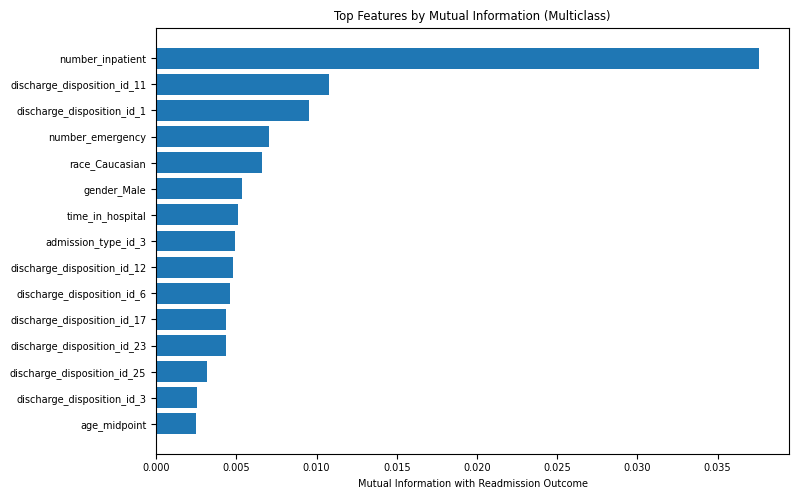

In [33]:
import matplotlib.pyplot as plt

top_n = 15
top_mi = mi_df.head(top_n)

plt.figure(figsize=(8, 5))
plt.barh(top_mi["feature"], top_mi["mutual_information"])
plt.gca().invert_yaxis()  # highest at top
plt.xlabel("Mutual Information with Readmission Outcome")
plt.title("Top Features by Mutual Information (Multiclass)")
plt.tight_layout()
plt.show()


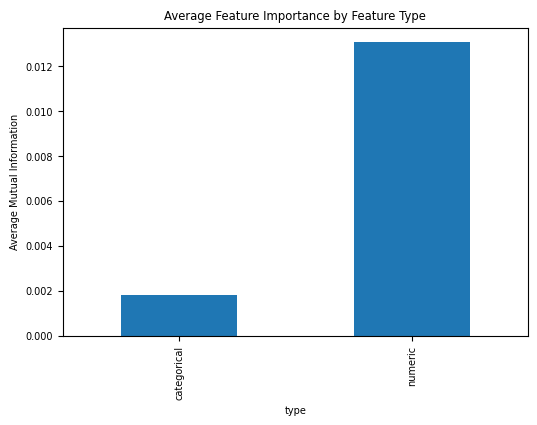

In [31]:
mi_df["type"] = mi_df["feature"].apply(
    lambda x: "numeric" if x in numerical_features else "categorical"
)

plt.figure(figsize=(6,4))
mi_df.groupby("type")["mutual_information"].mean().plot(kind="bar")
plt.ylabel("Average Mutual Information")
plt.title("Average Feature Importance by Feature Type")
plt.show()


In [35]:
# Lasso regression model to understand most important features
from sklearn.linear_model import LogisticRegression
import numpy as np
import pandas as pd

lasso = LogisticRegression(
    penalty="l1",
    solver="saga",
    C=0.5,              # smaller = stronger feature selection
    max_iter=5000,
    random_state=42
)

lasso.fit(X_dense, y)

# coefficients shape: (n_classes, n_features)
coef = lasso.coef_

# average absolute weight across classes
mean_abs_coef = np.mean(np.abs(coef), axis=0)

lasso_df = pd.DataFrame({
    "feature": feature_names,
    "importance": mean_abs_coef
}).sort_values("importance", ascending=False)

# selected features (non-zero)
selected_df = lasso_df[lasso_df["importance"] > 0]

print("Total features:", len(feature_names))
print("Selected by LASSO:", selected_df.shape[0])

selected_df.head(15)


/Users/varunsrinivasan/Documents/University/Year 3/Data Mining & Analysis/BENG0095CW/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/Users/varunsrinivasan/Documents/University/Year 3/Data Mining & Analysis/BENG0095CW/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1160: UserWarning: Inconsistent values: penalty=l1 with l1_ratio=0.0. penalty is deprecated. Please use l1_ratio only.
  warnings.warn(


Total features: 45
Selected by LASSO: 36


,feature,importance
25,discharge_disposition_id_11,2.311911
28,discharge_disposition_id_14,1.129587
27,discharge_disposition_id_13,0.655915
13,admission_type_id_7,0.508232
29,discharge_disposition_id_15,0.470474
40,discharge_disposition_id_28,0.465109
23,discharge_disposition_id_9,0.362014
35,discharge_disposition_id_22,0.344798
36,discharge_disposition_id_23,0.254913
19,discharge_disposition_id_5,0.221240


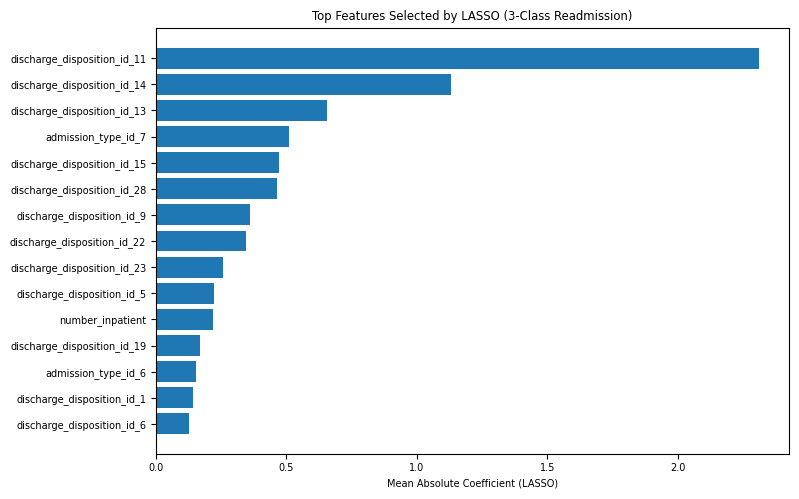

In [36]:
import matplotlib.pyplot as plt

top_n = 15
top_lasso = lasso_df.head(top_n)

plt.figure(figsize=(8,5))
plt.barh(top_lasso["feature"], top_lasso["importance"])
plt.gca().invert_yaxis()
plt.xlabel("Mean Absolute Coefficient (LASSO)")
plt.title("Top Features Selected by LASSO (3-Class Readmission)")
plt.tight_layout()
plt.show()

In [37]:
from sklearn.linear_model import LogisticRegression
import numpy as np
import pandas as pd

ridge = LogisticRegression(
    penalty="l2",       # Ridge
    solver="lbfgs",
    C=1.0,              # smaller = stronger regularisation
    max_iter=5000,
    random_state=42
)

ridge.fit(X_dense, y)

coef = ridge.coef_    # shape: (n_classes, n_features)

mean_abs_coef = np.mean(np.abs(coef), axis=0)

ridge_df = pd.DataFrame({
    "feature": feature_names,
    "importance": mean_abs_coef
}).sort_values("importance", ascending=False)

ridge_df.head(15)


/Users/varunsrinivasan/Documents/University/Year 3/Data Mining & Analysis/BENG0095CW/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(


,feature,importance
25,discharge_disposition_id_11,2.662440
28,discharge_disposition_id_14,0.958832
27,discharge_disposition_id_13,0.654641
29,discharge_disposition_id_15,0.622862
40,discharge_disposition_id_28,0.590228
35,discharge_disposition_id_22,0.446702
13,admission_type_id_7,0.410464
36,discharge_disposition_id_23,0.362486
19,discharge_disposition_id_5,0.340898
20,discharge_disposition_id_6,0.337121


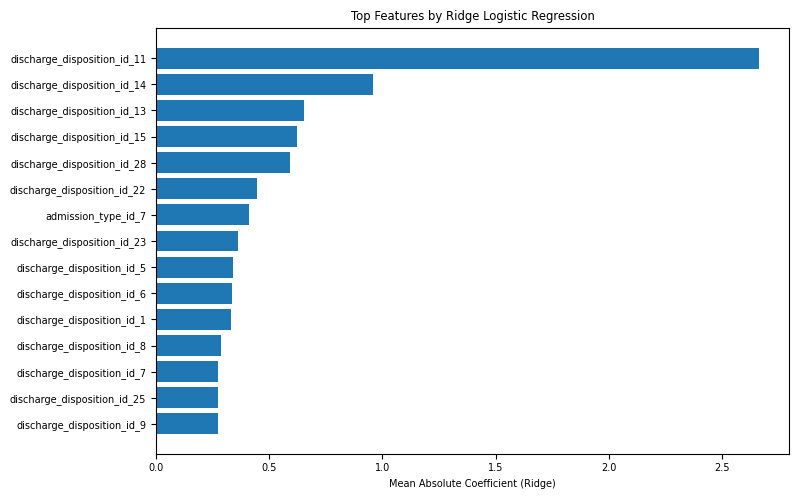

In [38]:
import matplotlib.pyplot as plt

top_n = 15
top_ridge = ridge_df.head(top_n)

plt.figure(figsize=(8,5))
plt.barh(top_ridge["feature"], top_ridge["importance"])
plt.gca().invert_yaxis()
plt.xlabel("Mean Absolute Coefficient (Ridge)")
plt.title("Top Features by Ridge Logistic Regression")
plt.tight_layout()
plt.show()


# 4. Methodology Overview
Code for the equivalent section in your report, together with in-line documentation of 
that code.

# 5. Model Training & Validation
Code for the equivalent section in your report, together with in-line documentation of 
that code.

In [11]:
# Binary classifier neural network

## Using: 'race','gender','age', 'admission_type_id','discharge_disposition_id'
##        'number_inpatient','number_emergency','time_in_hospital'

# Predicting: readmitted

import pandas as pd

cols = [
    'race','gender','age_midpoint',
    'admission_type_id','discharge_disposition_id',
    'number_inpatient','number_emergency','time_in_hospital',
    'readmitted'
]
data = df[cols].copy()

# Race: drop unknown
data = data[data['race'] != '?']

# Gender: drop invalid
data = data[data['gender'] != 'Unknown/Invalid']

data["age_midpoint"].dropna()

# grouping readmittance into a binary (YES/NO) field
# Collapse the 3-class target into a binary readmitted vs NO label
data['readmit_binary'] = (data['readmitted'] != 'NO').astype(int)


In [12]:

from sklearn.model_selection import train_test_split

X = data[[
    'race','gender','age_midpoint',
    'admission_type_id','discharge_disposition_id',
    'number_inpatient','number_emergency','time_in_hospital'
]]

y = data['readmit_binary']

# One-hot encode race, gender
X = pd.get_dummies(X, columns=['race','gender'], drop_first=True)

# Train-test split
X_train_nn, X_test_nn, y_train_nn, y_test_nn = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [170]:
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

numeric = [
    'age_midpoint','admission_type_id','discharge_disposition_id',
    'number_inpatient','number_emergency','time_in_hospital'
]

# Scale numeric features so the NN trains stably
scaler = StandardScaler()
X_train_nn[numeric] = scaler.fit_transform(X_train_nn[numeric])
X_test_nn[numeric] = scaler.transform(X_test_nn[numeric])


# Define a simple feed-forward network for the binary readmission task
binary_nn_model = Sequential([
    Dense(32, activation="relu", input_shape=(X_test_nn.shape[1],)),
    Dense(16, activation="relu"),
    Dense(8, activation="relu"),
    Dense(4, activation="relu"),
    Dense(1, activation="sigmoid")
])

# Use binary cross-entropy for the YES/NO readmission target
binary_nn_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Train with a held-out validation split to monitor overfitting
history = binary_nn_model.fit(
    X_train_nn, y_train_nn,
    validation_split=0.2,
    epochs=20,
    batch_size=32,
    verbose=1
)


Epoch 1/20


/Users/tneethesh/Desktop/BENG Coursework/BENG0095CW/.venv/lib/python3.13/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1791/1791 ━━━━━━━━━━━━━━━━━━━━ 2s 427us/step - accuracy: 0.6084 - loss: 0.6598 - val_accuracy: 0.6184 - val_loss: 0.6544
Epoch 2/20
1791/1791 ━━━━━━━━━━━━━━━━━━━━ 1s 377us/step - accuracy: 0.6177 - loss: 0.6522 - val_accuracy: 0.6195 - val_loss: 0.6519
Epoch 3/20
1791/1791 ━━━━━━━━━━━━━━━━━━━━ 1s 378us/step - accuracy: 0.6209 - loss: 0.6497 - val_accuracy: 0.6221 - val_loss: 0.6475
Epoch 4/20
1791/1791 ━━━━━━━━━━━━━━━━━━━━ 1s 438us/step - accuracy: 0.6230 - loss: 0.6468 - val_accuracy: 0.6218 - val_loss: 0.6466
Epoch 5/20
1791/1791 ━━━━━━━━━━━━━━━━━━━━ 1s 381us/step - accuracy: 0.6245 - loss: 0.6439 - val_accuracy: 0.6244 - val_loss: 0.6452
Epoch 6/20
1791/1791 ━━━━━━━━━━━━━━━━━━━━ 1s 376us/step - accuracy: 0.6246 - loss: 0.6423 - val_accuracy: 0.6249 - val_loss: 0.6438
Epoch 7/20
1791/1791 ━━━━━━━━━━━━━━━━━━━━ 1s 375us/step - accuracy: 0.6248 - loss: 0.6412 - val_accuracy: 0.6295 - val_loss: 0.6419
Epoch 8/20
1791/1791 ━━━━━━━━━━━━━━━━━━━━ 1s 378us/step - accuracy: 0.6244 - loss: 0.64

In [13]:
# 3 way logistic regression model

import pandas as pd

from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

train_df = df.copy()

features = categorical_features + numerical_features

X_train_log_reg = train_df[features]
y_train_log_reg = train_df['readmitted']

label_encoder = LabelEncoder()

y_train_enc = label_encoder.fit_transform(y_train_log_reg)


In [14]:
# fitting regression model to the training data
# Pipeline ties preprocessing and model training together
log_reg_model = Pipeline(steps=[
    ('preprocessor', make_preprocessor()),
    ('classifier', LogisticRegression(
        solver='lbfgs',
        max_iter=1000
    ))
])

# Fit the multi-class logistic regression model
log_reg_model.fit(X_train_log_reg, y_train_enc)

y_pred_log_reg = log_reg_model.predict(X_train_log_reg)


In [13]:
# =========================
# Kernel SVM for 3-way classification
# =========================

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import pandas as pd

train_df = df.copy()

# Kernel SVMs are expensive to train.
# To reduce training time, randomly sample 30% of the training data.
train_df = train_df.sample(frac=0.3, random_state=42)

features = categorical_features + numerical_features

# Input features
X_train_svm = train_df[features]

# Target variable (3-way readmission classification)
y_train_svm = train_df['readmitted']

# Build SVM pipeline
svm_model = Pipeline(steps=[
    ('preprocessor', make_preprocessor()),
    ('classifier', SVC(
        kernel='rbf',                  
        gamma='scale',                 
        decision_function_shape='ovr', 
        C=1.0,                         
        cache_size=500,                
        verbose=1 
    ))
])

# Model training and fitting
# Train on the sampled subset for speed
svm_model.fit(X_train_svm, y_train_svm)

# Predict class labels on the training set
y_train_pred_svm = svm_model.predict(X_train_svm)


[LibSVM].................
*.....................................................
*.
*
optimization finished, #iter = 71198
obj = -5806.486573, rho = 0.674850
nSV = 7043, nBSV = 5019
................
*.....................................................
*...
*
optimization finished, #iter = 72673
obj = -5672.351905, rho = 0.122033
nSV = 7097, nBSV = 4892
........................
*.....................................................
*.
*
optimization finished, #iter = 78365
obj = -16810.421943, rho = -0.274781
nSV = 17911, nBSV = 16306
Total nSV = 22013


In [174]:
# Naive Bayes (3-way classification) using helper preprocessing
from sklearn.naive_bayes import GaussianNB

# Reuse helper feature lists so preprocessing is consistent
features_nb = categorical_features + numerical_features
X_train_nb = df[features_nb]
y_train_nb = df["readmitted"]

nb_preprocessor = make_preprocessor()
# GaussianNB expects dense numeric input
X_train_nb_proc = nb_preprocessor.fit_transform(X_train_nb)
if hasattr(X_train_nb_proc, "toarray"):
    X_train_nb_proc = X_train_nb_proc.toarray()

# Train a simple generative baseline for 3-class prediction
nb_model = GaussianNB()
nb_model.fit(X_train_nb_proc, y_train_nb)


,"priors priors: array-like of shape (n_classes,), default=NonePrior probabilities of the classes. If specified, the priors are notadjusted according to the data.",None
,"var_smoothing var_smoothing: float, default=1e-9Portion of the largest variance of all features that is added tovariances for calculation stability... versionadded:: 0.20",1e-09


In [175]:
# MLP (3-way classification) using helper preprocessing
from sklearn.neural_network import MLPClassifier

# Reuse the same preprocessing so comparisons are fair
features_mlp = categorical_features + numerical_features
X_train_mlp = df[features_mlp]
y_train_mlp = df["readmitted"]

mlp_preprocessor = make_preprocessor()
X_train_mlp_proc = mlp_preprocessor.fit_transform(X_train_mlp)
if hasattr(X_train_mlp_proc, "toarray"):
    X_train_mlp_proc = X_train_mlp_proc.toarray()

# MLP provides a non-linear baseline with modest capacity
mlp_model = MLPClassifier(
    hidden_layer_sizes=(64, 32),
    activation="relu",
    solver="adam",
    max_iter=200,
    random_state=42,
)
mlp_model.fit(X_train_mlp_proc, y_train_mlp)


/Users/tneethesh/Desktop/BENG Coursework/BENG0095CW/.venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


,"hidden_layer_sizes hidden_layer_sizes: array-like of shape(n_layers - 2,), default=(100,)The ith element represents the number of neurons in the ithhidden layer.","(64, ...)"
,"activation activation: {'identity', 'logistic', 'tanh', 'relu'}, default='relu'Activation function for the hidden layer.- 'identity', no-op activation, useful to implement linear bottleneck, returns f(x) = x- 'logistic', the logistic sigmoid function, returns f(x) = 1 / (1 + exp(-x)).- 'tanh', the hyperbolic tan function, returns f(x) = tanh(x).- 'relu', the rectified linear unit function, returns f(x) = max(0, x)",'relu'
,"solver solver: {'lbfgs', 'sgd', 'adam'}, default='adam'The solver for weight optimization.- 'lbfgs' is an optimizer in the family of quasi-Newton methods.- 'sgd' refers to stochastic gradient descent.- 'adam' refers to a stochastic gradient-based optimizer proposed by Kingma, Diederik, and Jimmy BaFor a comparison between Adam optimizer and SGD, see:ref:`sphx_glr_auto_examples_neural_networks_plot_mlp_training_curves.py`.Note: The default solver 'adam' works pretty well on relativelylarge datasets (with thousands of training samples or more) in terms ofboth training time and validation score.For small datasets, however, 'lbfgs' can converge faster and performbetter.",'adam'
,"alpha alpha: float, default=0.0001Strength of the L2 regularization term. The L2 regularization termis divided by the sample size when added to the loss.For an example usage and visualization of varying regularization, see:ref:`sphx_glr_auto_examples_neural_networks_plot_mlp_alpha.py`.",0.0001
,"batch_size batch_size: int, default='auto'Size of minibatches for stochastic optimizers.If the solver is 'lbfgs', the classifier will not use minibatch.When set to ""auto"", `batch_size=min(200, n_samples)`.",'auto'
,"learning_rate learning_rate: {'constant', 'invscaling', 'adaptive'}, default='constant'Learning rate schedule for weight updates.- 'constant' is a constant learning rate given by 'learning_rate_init'.- 'invscaling' gradually decreases the learning rate at each time step 't' using an inverse scaling exponent of 'power_t'. effective_learning_rate = learning_rate_init / pow(t, power_t)- 'adaptive' keeps the learning rate constant to 'learning_rate_init' as long as training loss keeps decreasing. Each time two consecutive epochs fail to decrease training loss by at least tol, or fail to increase validation score by at least tol if 'early_stopping' is on, the current learning rate is divided by 5.Only used when ``solver='sgd'``.",'constant'
,"learning_rate_init learning_rate_init: float, default=0.001The initial learning rate used. It controls the step-sizein updating the weights. Only used when solver='sgd' or 'adam'.",0.001
,"power_t power_t: float, default=0.5The exponent for inverse scaling learning rate.It is used in updating effective learning rate when the learning_rateis set to 'invscaling'. Only used when solver='sgd'.",0.5
,"max_iter max_iter: int, default=200Maximum number of iterations. The solver iterates until convergence(determined by 'tol') or this number of iterations. For stochasticsolvers ('sgd', 'adam'), note that this determines the number of epochs(how many times each data point will be used), not the number ofgradient steps.",200
,"shuffle shuffle: bool, default=TrueWhether to shuffle samples in each iteration. Only used whensolver='sgd' or 'adam'.",True
,"random_state random_state: int, RandomState instance, default=NoneDetermines random number generation for weights and biasinitialization, train-test split if early stopping is used, and batchsampling when solver='sgd' or 'adam'.Pass an int for reproducible results across multiple function calls.See :term:`Glossary `.",42


In [ ]:
# Two-stage model: Naive Bayes for readmitted vs NO, SVM for <30 vs >30
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

features_two_stage = categorical_features + numerical_features
X_two_stage = df[features_two_stage]
y_two_stage = df["readmitted"]

# GaussianNB requires dense input, so convert after preprocessing
to_dense = FunctionTransformer(
    lambda x: x.toarray() if hasattr(x, "toarray") else x,
    accept_sparse=True,
)
# Stage 1: binary readmission gate (YES/NO)
stage1_nb = Pipeline(steps=[
    ("preprocessor", make_preprocessor()),
    ("to_dense", to_dense),
    ("classifier", GaussianNB()),
])

y1_full = (y_two_stage != "NO").astype(int)
stage1_nb.fit(X_two_stage, y1_full)

# Stage 2: only predict <30 vs >30 for readmitted patients
stage2_svm = Pipeline(steps=[
    ("preprocessor", make_preprocessor()),
    ("classifier", SVC(
        kernel="rbf",
        gamma="scale",
        decision_function_shape="ovr",
        C=1.0,
        cache_size=500,
    )),
])

readmit_mask_full = y_two_stage != "NO"
# If training is too slow, you can sample the readmitted subset here.
# readmit_sample = X_two_stage[readmit_mask_full].sample(frac=0.3, random_state=42)
# y_readmit_sample = y_two_stage[readmit_mask_full].loc[readmit_sample.index]
# stage2_svm.fit(readmit_sample, y_readmit_sample)

stage2_svm.fit(X_two_stage[readmit_mask_full], y_two_stage[readmit_mask_full])


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('classifier', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('cat', ...), ('num', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transforme

# 6. Results
Code for the equivalent section in your report, together with in-line documentation of 
that code.

In [178]:
# inference of the binary neural network on the training dataset
from sklearn.metrics import accuracy_score, classification_report

# Predict probabilities on training data
y_train_prob = binary_nn_model.predict(X_train_nn)

# Convert probabilities to class labels (0/1)
y_train_pred = (y_train_prob > 0.5).astype("int32").ravel()

# Evaluation on training data
print("Training Accuracy:", accuracy_score(y_train_nn, y_train_pred))
print("Training Classification Report:")
print(classification_report(y_train_nn, y_train_pred))


2239/2239 ━━━━━━━━━━━━━━━━━━━━ 1s 248us/step
Training Accuracy: 0.628122251232146
Training Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.75      0.68     38365
           1       0.63      0.49      0.55     33258

    accuracy                           0.63     71623
   macro avg       0.63      0.62      0.62     71623
weighted avg       0.63      0.63      0.62     71623



In [15]:
# inference of logistic regression model on the training data
print("Accuracy:", accuracy_score(y_train_enc, y_pred_log_reg))
print(classification_report(
    y_train_enc,
    y_pred_log_reg,
    target_names=label_encoder.classes_
))


Accuracy: 0.5722950105552391
              precision    recall  f1-score   support

         <30       0.39      0.02      0.04     10076
         >30       0.51      0.25      0.33     31496
          NO       0.59      0.90      0.71     47957

    accuracy                           0.57     89529
   macro avg       0.49      0.39      0.36     89529
weighted avg       0.54      0.57      0.50     89529



In [180]:
# Inference of Kernel SVM model on training data
from sklearn.metrics import accuracy_score, classification_report
print("SVM Model Training Results:")
print("Accuracy:", accuracy_score(y_train_svm, y_train_pred_svm))
print("\nClassification Report:")
print(classification_report(
    y_train_svm,
    y_train_pred_svm,
    target_names=['Not Readmitted', 'Readmitted >30 Days', 'Readmitted <30 Days']
))


SVM Model Training Results:
Accuracy: 0.5891879816821177

Classification Report:
                     precision    recall  f1-score   support

     Not Readmitted       0.85      0.02      0.04      2986
Readmitted >30 Days       0.53      0.34      0.41      9465
Readmitted <30 Days       0.61      0.87      0.71     14408

           accuracy                           0.59     26859
          macro avg       0.66      0.41      0.39     26859
       weighted avg       0.61      0.59      0.53     26859



In [181]:
# Inference of Naive Bayes model on training data
from sklearn.metrics import accuracy_score, classification_report

labels_nb = ["NO", ">30", "<30"]

y_train_pred_nb = nb_model.predict(X_train_nb_proc)

print("Naive Bayes Training Results:")
print("Accuracy:", accuracy_score(y_train_nb, y_train_pred_nb))
print(classification_report(
    y_train_nb,
    y_train_pred_nb,
    labels=labels_nb,
    target_names=labels_nb
))


Naive Bayes Training Results:
Accuracy: 0.14135084721151805
              precision    recall  f1-score   support

          NO       0.92      0.05      0.09     47957
         >30       0.38      0.02      0.03     31496
         <30       0.12      0.98      0.21     10076

    accuracy                           0.14     89529
   macro avg       0.47      0.35      0.11     89529
weighted avg       0.64      0.14      0.08     89529



In [182]:
# Inference of MLP model on training data
from sklearn.metrics import accuracy_score, classification_report

labels_mlp = ["NO", ">30", "<30"]

y_train_pred_mlp = mlp_model.predict(X_train_mlp_proc)

print("MLP Training Results:")
print("Accuracy:", accuracy_score(y_train_mlp, y_train_pred_mlp))
print(classification_report(
    y_train_mlp,
    y_train_pred_mlp,
    labels=labels_mlp,
    target_names=labels_mlp
))


MLP Training Results:
Accuracy: 0.598856236526712
              precision    recall  f1-score   support

          NO       0.62      0.87      0.72     47957
         >30       0.54      0.36      0.43     31496
         <30       0.61      0.08      0.14     10076

    accuracy                           0.60     89529
   macro avg       0.59      0.43      0.43     89529
weighted avg       0.59      0.60      0.55     89529



In [183]:
# Two-stage model training results (NB -> SVM)
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

# Stage 1 evaluation
y1_pred_full = stage1_nb.predict(X_two_stage)
print("Two-stage Stage 1 (NB): Readmitted vs NO")
print("Accuracy:", accuracy_score(y1_full, y1_pred_full))
print(classification_report(
    y1_full,
    y1_pred_full,
    target_names=["NO", "Readmitted"],
    zero_division=0,
))

# Stage 2 evaluation on true readmitted subset
y2_true = y_two_stage[readmit_mask_full]
y2_pred = stage2_svm.predict(X_two_stage[readmit_mask_full])
print("Two-stage Stage 2 (SVM): <30 vs >30")
print("Accuracy:", accuracy_score(y2_true, y2_pred))
print(classification_report(
    y2_true,
    y2_pred,
    labels=[">30", "<30"],
    target_names=[">30", "<30"],
    zero_division=0,
))

# Combined 3-class prediction
final_pred = np.array(["NO"] * len(y_two_stage), dtype=object)
readmit_pred_mask = y1_pred_full == 1
if readmit_pred_mask.any():
    final_pred[readmit_pred_mask] = stage2_svm.predict(X_two_stage[readmit_pred_mask])

print("Two-stage combined (3-class)")
print("Accuracy:", accuracy_score(y_two_stage, final_pred))
print(classification_report(
    y_two_stage,
    final_pred,
    labels=["NO", ">30", "<30"],
    target_names=["NO", ">30", "<30"],
    zero_division=0,
))


Two-stage Stage 1 (NB): Readmitted vs NO
Accuracy: 0.48950619352388614
              precision    recall  f1-score   support

          NO       0.87      0.06      0.10     47957
  Readmitted       0.48      0.99      0.64     41572

    accuracy                           0.49     89529
   macro avg       0.67      0.52      0.37     89529
weighted avg       0.69      0.49      0.35     89529

Two-stage Stage 2 (SVM): <30 vs >30
Accuracy: 0.7659482343885308
              precision    recall  f1-score   support

         >30       0.77      0.99      0.86     31496
         <30       0.65      0.07      0.13     10076

    accuracy                           0.77     41572
   macro avg       0.71      0.53      0.50     41572
weighted avg       0.74      0.77      0.69     41572

Two-stage combined (3-class)
Accuracy: 0.38192094181773506
              precision    recall  f1-score   support

          NO       0.87      0.06      0.10     47957
         >30       0.36      0.98      0.5

# 7. Final Predictions on Test Set
Code for the equivalent section in your report, together with in-line documentation of 
that code.

In [184]:

# inference of the binary neural network model

y_pred = (binary_nn_model.predict(X_test_nn) > 0.5).astype("int32")

print("Accuracy:", accuracy_score(y_test_nn, y_pred))
print("\nClassification report:")
print(classification_report(y_test_nn, y_pred))


560/560 ━━━━━━━━━━━━━━━━━━━━ 0s 177us/step
Accuracy: 0.6326371048810454

Classification report:
              precision    recall  f1-score   support

           0       0.63      0.76      0.69      9592
           1       0.64      0.49      0.55      8314

    accuracy                           0.63     17906
   macro avg       0.63      0.62      0.62     17906
weighted avg       0.63      0.63      0.63     17906



In [185]:

# inference of the 3-way logistic regression model
test_df = test_df.copy()

test_df["age_midpoint"] = test_df['age'].apply(get_age_mid)

test_df = test_df[
    (test_df['race'] != '?') &
    (test_df['gender'] != 'Unknown/Invalid')
]

X_test_log_reg = test_df[features]
y_test_log_reg = test_df['readmitted']

y_test_enc = label_encoder.transform(y_test_log_reg)

y_test_pred = log_reg_model.predict(X_test_log_reg)

print("Test Accuracy:", accuracy_score(y_test_enc, y_test_pred))
print(classification_report(
    y_test_enc,
    y_test_pred,
    target_names=label_encoder.classes_
))


Test Accuracy: 0.5754290876242095
              precision    recall  f1-score   support

         <30       0.42      0.02      0.05      1093
         >30       0.51      0.25      0.34      3511
          NO       0.59      0.90      0.71      5359

    accuracy                           0.58      9963
   macro avg       0.51      0.39      0.37      9963
weighted avg       0.54      0.58      0.51      9963



In [187]:
# Inference of Naive Bayes model on test data (using helper preprocessing)

# Temporarily reuse helper cleaning on test data
_df_backup = df

df = pd.read_csv(TEST_DATA_FILEPATH)

df["age_midpoint"] = df["age"].apply(get_age_mid)
clean_inpatient_data()
clean_patient_interaction_cols()
standard_cleaning()

test_df_nb = df.copy()

df = _df_backup

X_test_nb = test_df_nb[features_nb]
y_test_nb = test_df_nb["readmitted"]

X_test_nb_proc = nb_preprocessor.transform(X_test_nb)
if hasattr(X_test_nb_proc, "toarray"):
    X_test_nb_proc = X_test_nb_proc.toarray()

y_test_pred_nb = nb_model.predict(X_test_nb_proc)

print("Naive Bayes Test Results:")
print("Accuracy:", accuracy_score(y_test_nb, y_test_pred_nb))
print(classification_report(
    y_test_nb,
    y_test_pred_nb,
    labels=labels_nb,
    target_names=labels_nb
))


Naive Bayes Test Results:
Accuracy: 0.13911472448057813
              precision    recall  f1-score   support

          NO       0.93      0.05      0.10      5359
         >30       0.28      0.01      0.02      3511
         <30       0.11      0.99      0.20      1093

    accuracy                           0.14      9963
   macro avg       0.44      0.35      0.11      9963
weighted avg       0.61      0.14      0.08      9963



In [188]:
# Inference of MLP model on test data (using helper preprocessing)
from sklearn.metrics import accuracy_score, classification_report

# Temporarily reuse helper cleaning on test data
_df_backup = df

df = pd.read_csv(TEST_DATA_FILEPATH)

df["age_midpoint"] = df["age"].apply(get_age_mid)
clean_inpatient_data()
clean_patient_interaction_cols()
standard_cleaning()

test_df_mlp = df.copy()

df = _df_backup

X_test_mlp = test_df_mlp[features_mlp]
y_test_mlp = test_df_mlp["readmitted"]

X_test_mlp_proc = mlp_preprocessor.transform(X_test_mlp)
if hasattr(X_test_mlp_proc, "toarray"):
    X_test_mlp_proc = X_test_mlp_proc.toarray()

y_test_pred_mlp = mlp_model.predict(X_test_mlp_proc)

labels_mlp = ["NO", ">30", "<30"]

print("MLP Test Results:")
print("Accuracy:", accuracy_score(y_test_mlp, y_test_pred_mlp))
print(classification_report(
    y_test_mlp,
    y_test_pred_mlp,
    labels=labels_mlp,
    target_names=labels_mlp
))


MLP Test Results:
Accuracy: 0.5671986349493124
              precision    recall  f1-score   support

          NO       0.60      0.83      0.70      5359
         >30       0.48      0.33      0.39      3511
         <30       0.32      0.04      0.07      1093

    accuracy                           0.57      9963
   macro avg       0.47      0.40      0.38      9963
weighted avg       0.53      0.57      0.52      9963



In [189]:
# Two-stage model test results (NB -> SVM)
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

# Prepare test data using helper cleaning
_df_backup = df

df = pd.read_csv(TEST_DATA_FILEPATH)

df["age_midpoint"] = df["age"].apply(get_age_mid)
clean_inpatient_data()
clean_patient_interaction_cols()
standard_cleaning()

test_df_two_stage = df.copy()

df = _df_backup

X_test_two_stage = test_df_two_stage[features_two_stage]
y_test_two_stage = test_df_two_stage["readmitted"]

# Stage 1 evaluation on test set
y1_test_pred = stage1_nb.predict(X_test_two_stage)
y1_test_true = (y_test_two_stage != "NO").astype(int)

print("Two-stage Stage 1 (NB) Test: Readmitted vs NO")
print("Accuracy:", accuracy_score(y1_test_true, y1_test_pred))
print(classification_report(
    y1_test_true,
    y1_test_pred,
    target_names=["NO", "Readmitted"],
    zero_division=0,
))

# Stage 2 evaluation on true readmitted subset
test_readmit_mask = y_test_two_stage != "NO"
y2_test_true = y_test_two_stage[test_readmit_mask]
y2_test_pred = stage2_svm.predict(X_test_two_stage[test_readmit_mask])

print("Two-stage Stage 2 (SVM) Test: <30 vs >30")
print("Accuracy:", accuracy_score(y2_test_true, y2_test_pred))
print(classification_report(
    y2_test_true,
    y2_test_pred,
    labels=[">30", "<30"],
    target_names=[">30", "<30"],
    zero_division=0,
))

# Combined 3-class prediction on test set
final_test_pred = np.array(["NO"] * len(y_test_two_stage), dtype=object)
readmit_pred_mask = y1_test_pred == 1
if readmit_pred_mask.any():
    final_test_pred[readmit_pred_mask] = stage2_svm.predict(X_test_two_stage[readmit_pred_mask])

print("Two-stage combined (3-class) Test")
print("Accuracy:", accuracy_score(y_test_two_stage, final_test_pred))
print(classification_report(
    y_test_two_stage,
    final_test_pred,
    labels=["NO", ">30", "<30"],
    target_names=["NO", ">30", "<30"],
    zero_division=0,
))


Two-stage Stage 1 (NB) Test: Readmitted vs NO
Accuracy: 0.48870822041553746
              precision    recall  f1-score   support

          NO       0.90      0.06      0.11      5359
  Readmitted       0.47      0.99      0.64      4604

    accuracy                           0.49      9963
   macro avg       0.69      0.52      0.37      9963
weighted avg       0.70      0.49      0.35      9963

Two-stage Stage 2 (SVM) Test: <30 vs >30
Accuracy: 0.7634665508253693
              precision    recall  f1-score   support

         >30       0.77      0.98      0.86      3511
         <30       0.52      0.06      0.11      1093

    accuracy                           0.76      4604
   macro avg       0.64      0.52      0.48      4604
weighted avg       0.71      0.76      0.68      4604

Two-stage combined (3-class) Test
Accuracy: 0.3804075077787815
              precision    recall  f1-score   support

          NO       0.90      0.06      0.11      5359
         >30       0.36     